## Setup enviroment

In [1]:
import os
import gc
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score, brier_score_loss, precision_recall_curve
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append(r'/home/jeanlr/projetos/lending-club/global')
from util import *
import optuna
import arfs.feature_selection.allrelevant as arfsgroot
import shap
import json
import joblib
from venn_abers import VennAbersCalibrator

sns.set(style='whitegrid')

/home/jeanlr/projetos/lending-club/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read train, validation and calibration data

In [2]:
train_df = pd.read_parquet('../data/processed/abt_train.parquet')
validation_df = pd.read_parquet('../data/processed/abt_validation.parquet')
calibration_df = pd.read_parquet('../data/processed/abt_calibration.parquet')
test_df = pd.read_parquet('../data/processed/abt_test.parquet')

In [3]:
categorical_column_names = train_df.select_dtypes(include=['category']).columns
categorical_column_names

Index(['grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'application_type'],
      dtype='object')

In [4]:
cat_features = ['grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'application_type']

## Train, Validation, Test Split

In [5]:
target = 'default'

# Input variables and Target dataframes
X_train, y_train= train_df.drop(target, axis=1), train_df.loc[:, target]
X_validation, y_validation= validation_df.drop(target, axis=1), validation_df.loc[:, target]
X_calibration, y_calibration= calibration_df.drop(target, axis=1), calibration_df.loc[:, target]

# Freeing memory
train_df = None
calibration_df = None
validation_df = None
gc.collect()

print('Train Shape: ', X_train.shape, y_train.shape)
print('Validation shape: ', X_validation.shape, y_validation.shape)
print('Calibration shape: ', X_calibration.shape, y_calibration.shape)

Train Shape:  (86641, 100) (86641,)
Validation shape:  (246072, 100) (246072,)
Calibration shape:  (61519, 100) (61519,)


In [6]:
print('Train Churn Values count:\n', y_train.value_counts())
print(y_train.value_counts(normalize=True))

Train Churn Values count:
 default
0.0    70963
1.0    15678
Name: count, dtype: int64
default
0.0    0.819046
1.0    0.180954
Name: proportion, dtype: float64


In [7]:
print('Validation Churn Values count:\n', y_validation.value_counts())
print(y_validation.value_counts(normalize=True))

Validation Churn Values count:
 default
0.0    196938
1.0     49134
Name: count, dtype: int64
default
0.0    0.800327
1.0    0.199673
Name: proportion, dtype: float64


In [8]:
print('Calibration Churn Values count:\n', y_calibration.value_counts())
print(y_calibration.value_counts(normalize=True))

Calibration Churn Values count:
 default
0.0    49235
1.0    12284
Name: count, dtype: int64
default
0.0    0.800322
1.0    0.199678
Name: proportion, dtype: float64


## Train a Vanilla Baseline CatBoost Model

In [9]:
# Using PRAUC Use Weights False to not inflat the PRAUC metric
baseline_params = {
    'iterations': 1000,
    'auto_class_weights': 'Balanced',
    'eval_metric': 'Logloss',
    'cat_features': cat_features,
    'verbose': True,
    'random_seed': 55,
    'max_depth': 8,
    'colsample_bylevel': 0.8,
    'subsample': 0.7,
    'learning_rate': 0.02,
    'early_stopping_rounds': 100
}
model = CatBoostClassifier(**baseline_params)

print('Traning the model...')
model.fit(X_train, y_train, eval_set=(X_validation, y_validation), early_stopping_rounds=100)

print('Evaluating the model...')
y_pred_baseline = model.predict_proba(X_validation)[:, 1]

Traning the model...
0:	learn: 0.6907249	test: 0.6906175	best: 0.6906175 (0)	total: 151ms	remaining: 2m 30s
1:	learn: 0.6882786	test: 0.6881814	best: 0.6881814 (1)	total: 238ms	remaining: 1m 58s
2:	learn: 0.6860529	test: 0.6858908	best: 0.6858908 (2)	total: 331ms	remaining: 1m 50s
3:	learn: 0.6839896	test: 0.6838391	best: 0.6838391 (3)	total: 409ms	remaining: 1m 41s
4:	learn: 0.6818062	test: 0.6815717	best: 0.6815717 (4)	total: 487ms	remaining: 1m 36s
5:	learn: 0.6796033	test: 0.6793602	best: 0.6793602 (5)	total: 558ms	remaining: 1m 32s
6:	learn: 0.6774880	test: 0.6772648	best: 0.6772648 (6)	total: 646ms	remaining: 1m 31s
7:	learn: 0.6757233	test: 0.6754251	best: 0.6754251 (7)	total: 724ms	remaining: 1m 29s
8:	learn: 0.6739580	test: 0.6731001	best: 0.6731001 (8)	total: 815ms	remaining: 1m 29s
9:	learn: 0.6721241	test: 0.6701999	best: 0.6701999 (9)	total: 896ms	remaining: 1m 28s
10:	learn: 0.6705931	test: 0.6687107	best: 0.6687107 (10)	total: 970ms	remaining: 1m 27s
11:	learn: 0.6689738

In [10]:
# Metrics Report
clf_metric_report(y_pred_baseline, y_validation)

Evaluating the model...
ROC AUC: 0.7238451070139131
Brier Score: 0.20820810891560274
Average Precision: 0.3991167263291786
Log Loss: 0.6012544039511277


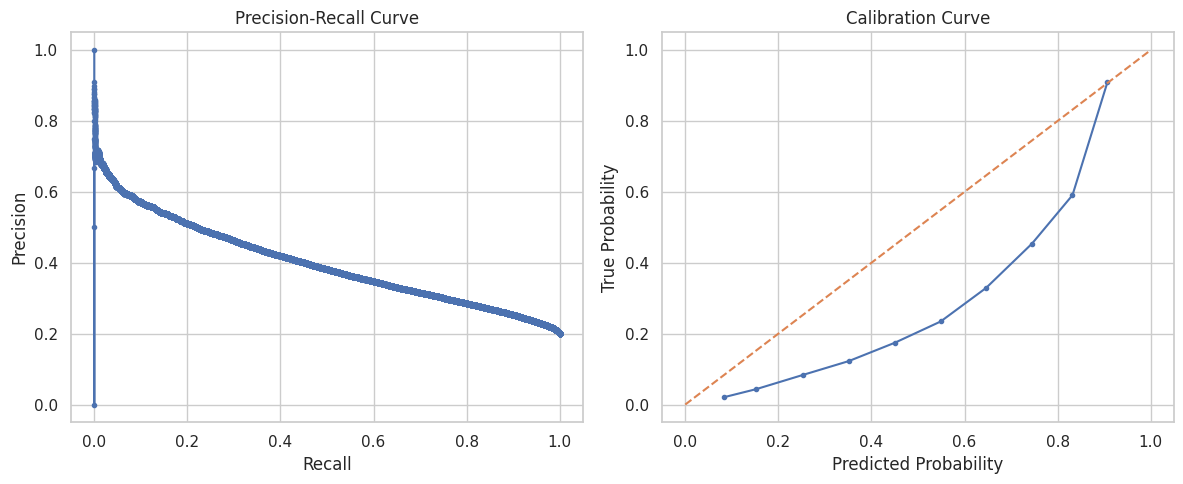

In [11]:
# PR Curve and Calibration curve
plot_pr_calib_curve(y_pred_baseline, y_validation)

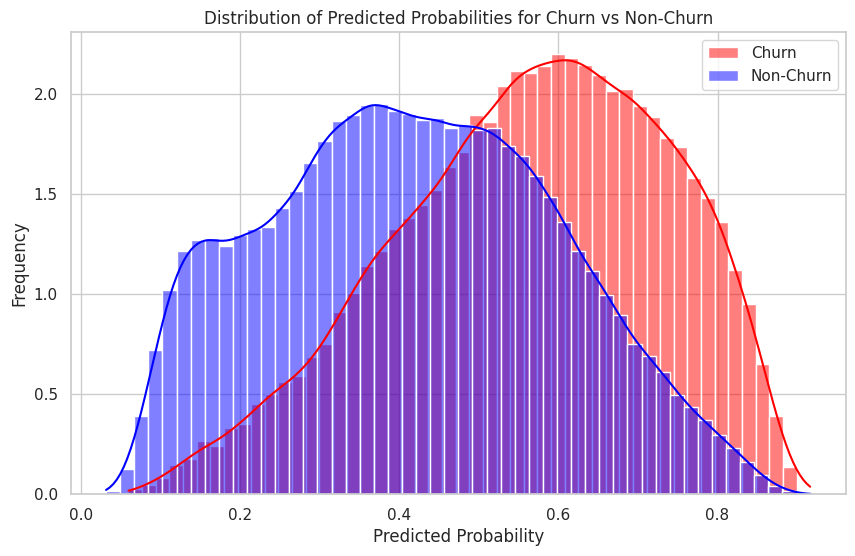

In [12]:
# Distribution of predicted probabilities
plot_dis_probs(y_pred_baseline, y_validation)

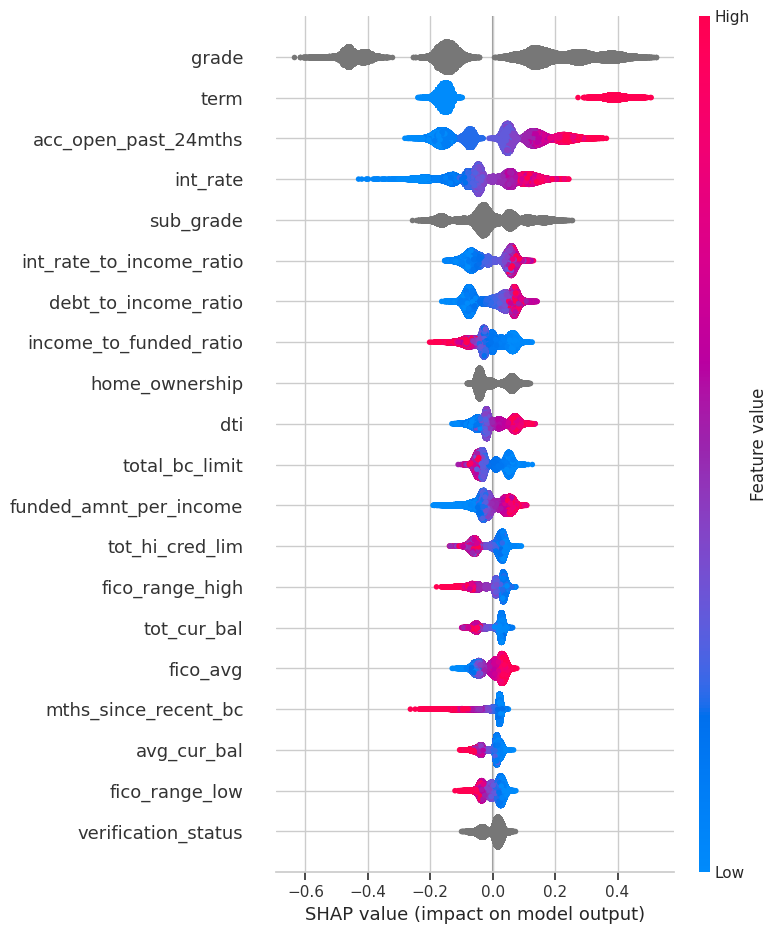

In [13]:
# SHAP Values
shap_explainer = shap.Explainer(model)
shap_values = shap_explainer(X_validation)
#shap.summary_plot(shap_values, X_validation, plot_type='dot', max_display=25)
shap.summary_plot(shap_values, X_validation)

## Feature Selection with Boruta

In [14]:
selected_features = None

In [15]:
# untuned, this is just a set of "reasonable defaults" to get better feature selection
feat_selection_params = {
    'random_strength': 1,
    'learning_rate': 0.02,
    'max_depth': 8,
    'colsample_bylevel': 0.8,
    'subsample': 0.7,
    'random_seed': 42,
    'auto_class_weights': 'Balanced',
    #'cat_features': cat_features,
    'verbose': False 
}

''''
Iteration: 	1 / 10
Confirmed: 	37
Tentative: 	47
Rejected: 	66
'''

model_for_feat_selection = CatBoostClassifier(**feat_selection_params) 

feat_selector = arfsgroot.Leshy(
    model_for_feat_selection, n_estimators=150, verbose=1, max_iter=10, random_state=55, importance="fastshap",
)

feat_selector.fit(X_train.drop(cat_features, axis=1), y_train)

/home/jeanlr/projetos/lending-club/.venv/lib/python3.12/site-packages/arfs/feature_selection/allrelevant.py:325: UserWarning: fasttreeshap is not installed. Fallback to shap.
  warnings.warn("fasttreeshap is not installed. Fallback to shap.")
/home/jeanlr/projetos/lending-club/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Leshy iteration: 100%|██████████| 10/10 [01:07<00:00,  6.74s/it]



Leshy finished running using shap var. imp.

Iteration: 	1 / 10
Confirmed: 	35
Tentative: 	9
Rejected: 	50
All relevant predictors selected in 00:01:07.47


Leshy(estimator=<catboost.core.CatBoostClassifier object at 0x755042d79b20>,
      max_iter=10, n_estimators=150,
      random_state=RandomState(MT19937) at 0x7550457F5040, verbose=1)

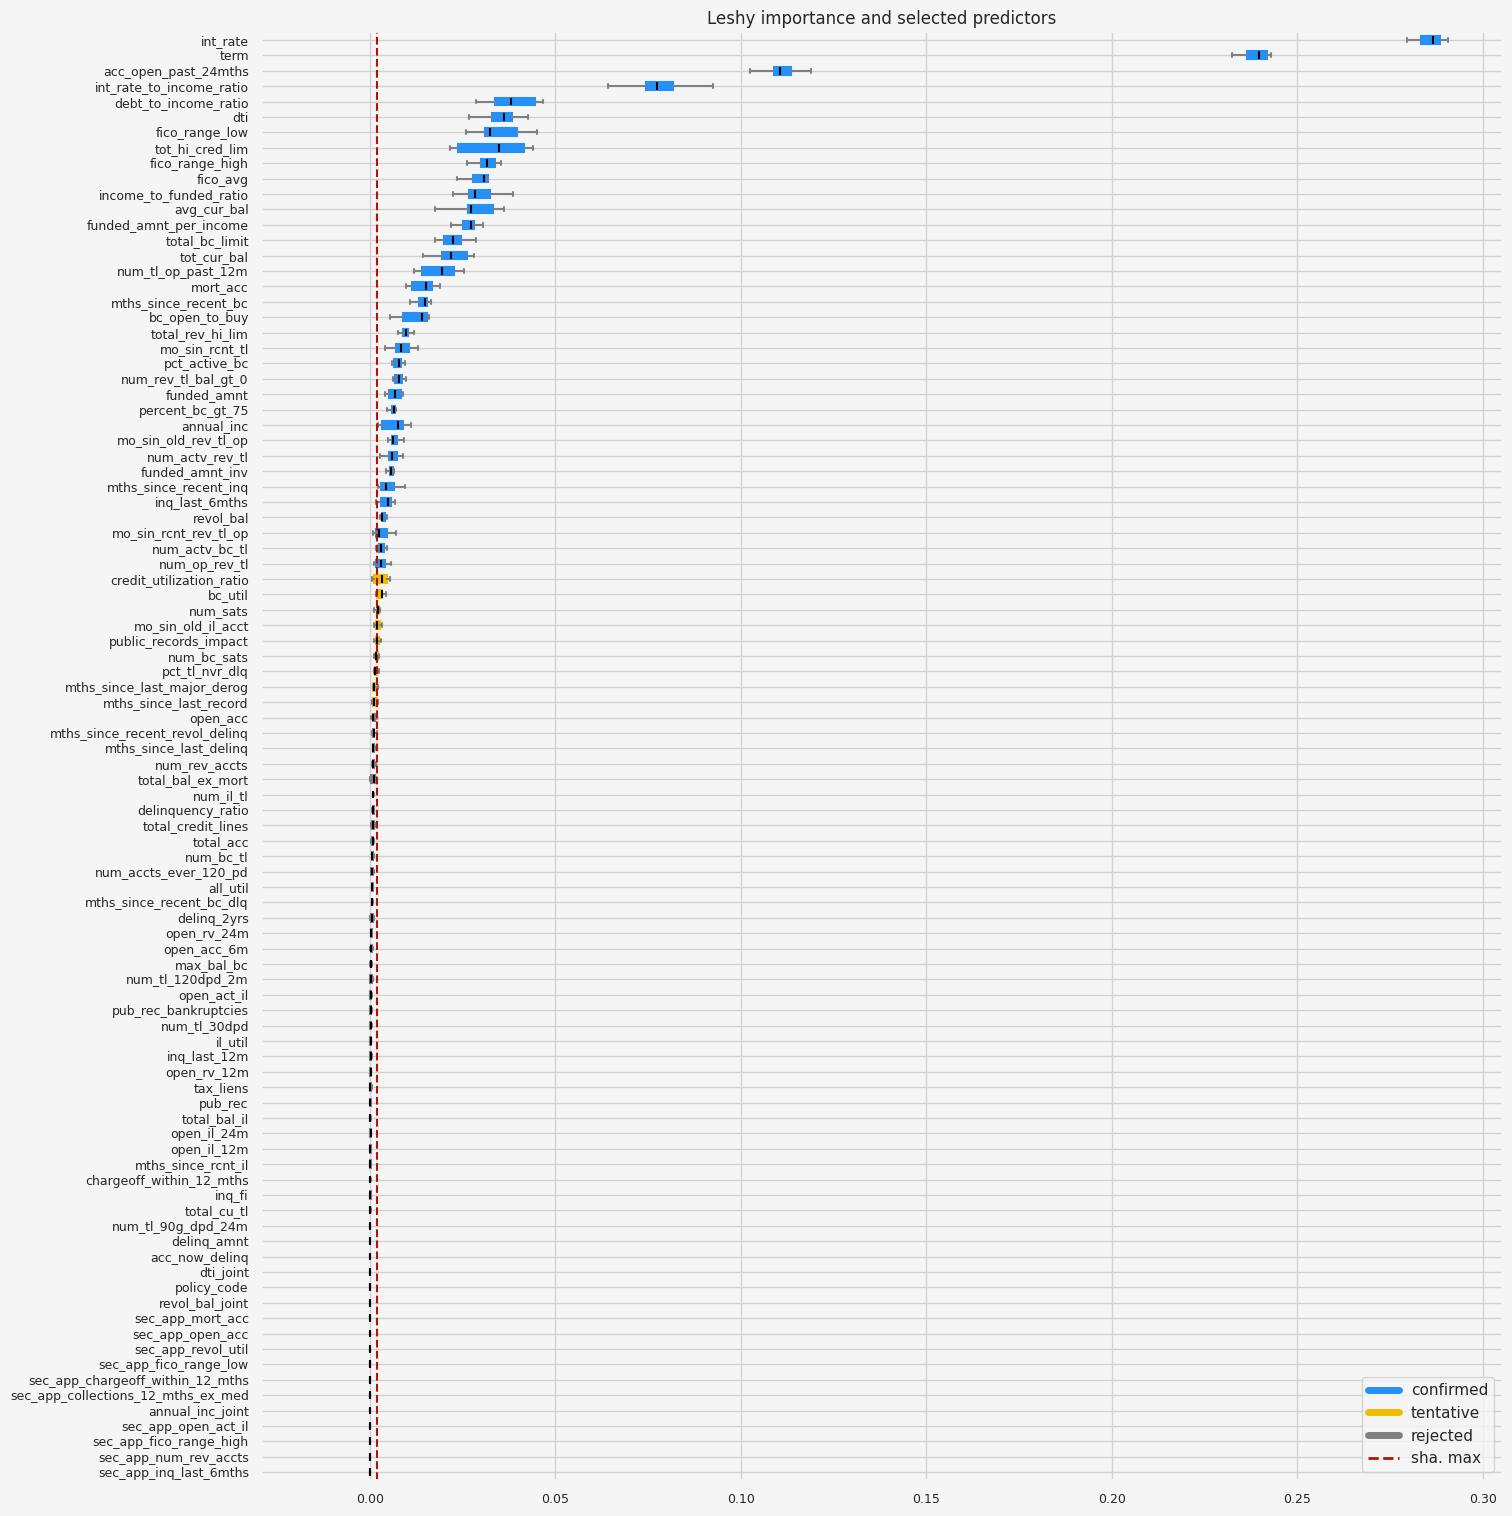

In [16]:
_ = feat_selector.plot_importance()

In [17]:
selected_features = feat_selector.get_feature_names_out().tolist() + cat_features

# Save the selected features
with open('../artifacts/selected_features_list.json', 'w') as f:
    json.dump(selected_features, f)

In [18]:
print(f"The selected features: {selected_features}")

The selected features: ['funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'annual_inc', 'dti', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'revol_bal', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'num_tl_op_past_12m', 'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bc_limit', 'income_to_funded_ratio', 'debt_to_income_ratio', 'funded_amnt_per_income', 'fico_avg', 'int_rate_to_income_ratio', 'pct_active_bc', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'application_type']


## Train a Vanilla CatBoost Model with Selected Features

In [19]:
if selected_features == None:
    with open('../artifacts/selected_features_list.json', 'r') as f:
        selected_features = json.load(f)

model_selected = CatBoostClassifier(**baseline_params)
model_selected.fit(X_train[selected_features], y_train, eval_set=(X_validation[selected_features], y_validation), early_stopping_rounds=200, verbose=True)

y_pred_selected = model_selected.predict_proba(X_validation[selected_features])[:, 1]

0:	learn: 0.6906632	test: 0.6906116	best: 0.6906116 (0)	total: 99.3ms	remaining: 1m 39s
1:	learn: 0.6883795	test: 0.6881895	best: 0.6881895 (1)	total: 172ms	remaining: 1m 25s
2:	learn: 0.6861452	test: 0.6858738	best: 0.6858738 (2)	total: 248ms	remaining: 1m 22s
3:	learn: 0.6839732	test: 0.6836409	best: 0.6836409 (3)	total: 347ms	remaining: 1m 26s
4:	learn: 0.6818085	test: 0.6814409	best: 0.6814409 (4)	total: 422ms	remaining: 1m 23s
5:	learn: 0.6796775	test: 0.6791719	best: 0.6791719 (5)	total: 500ms	remaining: 1m 22s
6:	learn: 0.6776711	test: 0.6771214	best: 0.6771214 (6)	total: 584ms	remaining: 1m 22s
7:	learn: 0.6758381	test: 0.6752633	best: 0.6752633 (7)	total: 662ms	remaining: 1m 22s
8:	learn: 0.6738629	test: 0.6732759	best: 0.6732759 (8)	total: 737ms	remaining: 1m 21s
9:	learn: 0.6721439	test: 0.6714803	best: 0.6714803 (9)	total: 829ms	remaining: 1m 22s
10:	learn: 0.6703679	test: 0.6697022	best: 0.6697022 (10)	total: 932ms	remaining: 1m 23s
11:	learn: 0.6687115	test: 0.6679612	bes

In [20]:
# Model metrics report
clf_metric_report(y_pred_selected, y_validation)

Evaluating the model...
ROC AUC: 0.7251291424019894
Brier Score: 0.19985954452561816
Average Precision: 0.40147491164752813
Log Loss: 0.5827367168790695


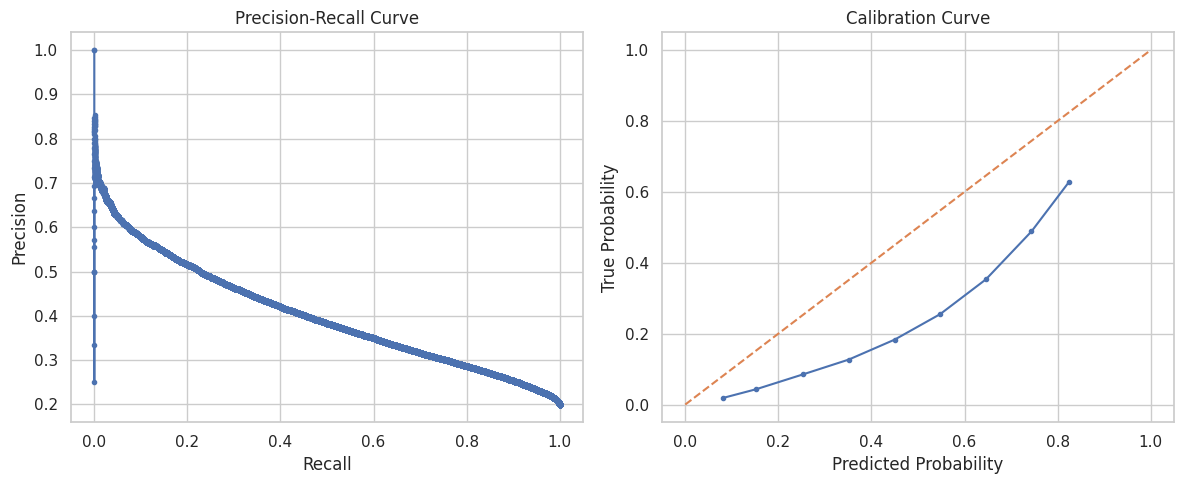

In [21]:
# PR Curve and Calibration curve
plot_pr_calib_curve(y_pred_selected, y_validation)

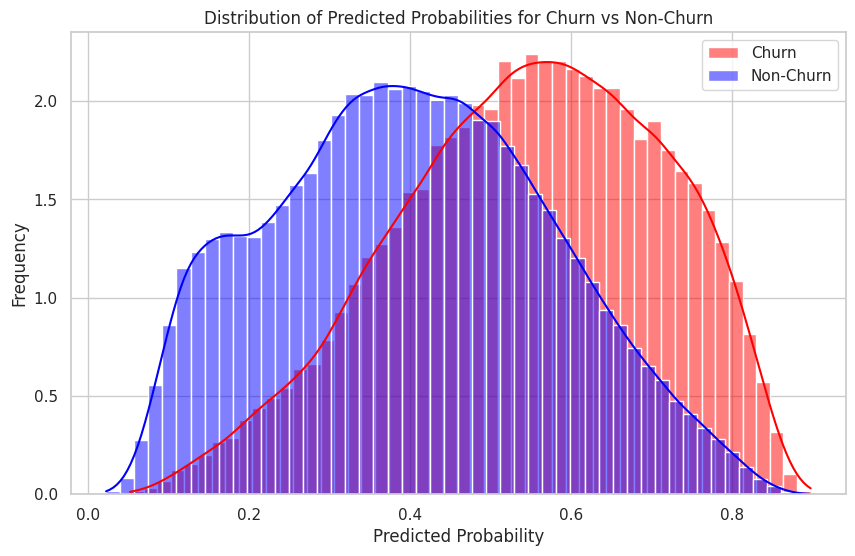

In [22]:
# Distribution of predicted probabilities
plot_dis_probs(y_pred_selected, y_validation)

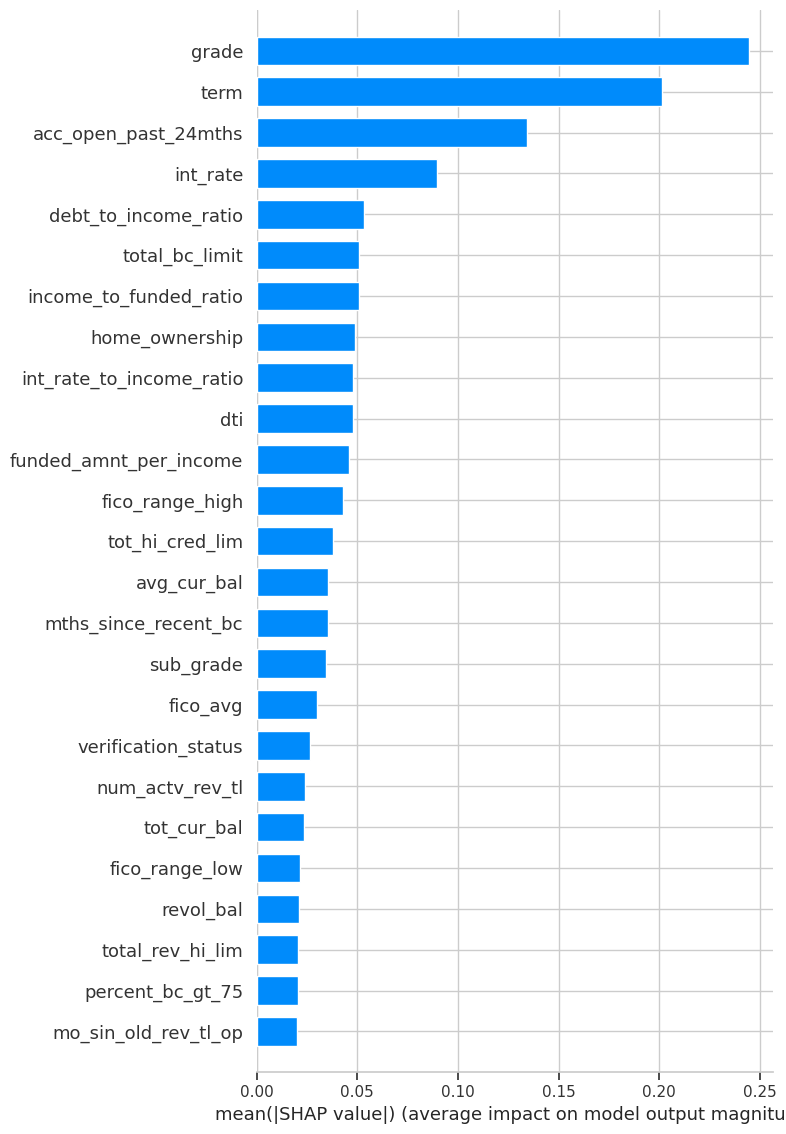

In [23]:
# SHAP Values
shape_explainer = shap.Explainer(model_selected)
shape_values = shape_explainer(X_validation[selected_features])
plot_shap_values(shape_values, X_validation[selected_features], y_validation)

## Comparing Baseline and the Feature Selected model

In [24]:
print('Baseline model')
clf_metric_report(y_pred_baseline, y_validation)
print('')

print('Feature selection model')
clf_metric_report(y_pred_selected, y_validation)
print('')

Baseline model
Evaluating the model...
ROC AUC: 0.7238451070139131
Brier Score: 0.20820810891560274
Average Precision: 0.3991167263291786
Log Loss: 0.6012544039511277

Feature selection model
Evaluating the model...
ROC AUC: 0.7251291424019894
Brier Score: 0.19985954452561816
Average Precision: 0.40147491164752813
Log Loss: 0.5827367168790695



In [25]:
print('Average precision improvement: ', (average_precision_score(y_validation, y_pred_selected) - average_precision_score(y_validation, y_pred_baseline)) / average_precision_score(y_validation, y_pred_baseline))


Average precision improvement:  0.0059085103749938325


## Saving the model and artifacts

In [26]:
# Save the baseline model
baseline_model_path = '../artifacts/baseline_model.joblib'
joblib.dump(model, baseline_model_path)

# Save the model trained with selected features
feat_selection_model_path = '../artifacts/feat_selection_model.joblib'
joblib.dump(model_selected, feat_selection_model_path)

print(f"Baseline model saved to: {baseline_model_path}")
print(f"Baseline model saved to: {feat_selection_model_path}")

Baseline model saved to: ../artifacts/baseline_model.joblib
Baseline model saved to: ../artifacts/feat_selection_model.joblib
